Let's start our Practical Session 2 : 


# Task 1

## Our first streaming using rate source


### Initialization SparkSession

In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Practical_2").getOrCreate()


### Let’s first import the required libraries.

*   Pyspark functions 
*   Pyspark Types



In [2]:
import pyspark.sql.functions as Fns
from pyspark.sql.types import *

### Create streaming DataFrame


Let’s create our first Spark Streaming DataFrame using "rate" format. Here we have specified the format as rate and specified rowsPerSecond = 1 to generate 1 row for each micro-batch and load the data into initDF streaming DataFrame. 

In [3]:
initDF = spark.readStream.format("rate") \
    .option("rowsPerSecond", 1)\
    .option("truncate", False)\
    .load()


### Check if DataFrame is streaming or Not.


In [4]:
initDF.isStreaming

True

### Transformation

Perform transformation on initDF to generate another column result by just adding 1 to column value :


### Output

In [5]:
initDf_one_added = initDF.withColumn('one_added', Fns.col('value') + Fns.lit(1))
q = initDf_one_added.writeStream.outputMode("append") \
    .format("console") \
    .start()

In [76]:
q.stop()

### Our Second streaming using rate source

### Create Streaming DataFrame

### Create Streaming DataFrame using socket source. Also, check if DataFrame isStreaming.


In [14]:
df = spark.readStream.format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

df.isStreaming

True

### Transformation: Word Count


Here we count words from a stream of data coming from this socket. Also, we check the schema of our streaming DataFrame.


In [15]:
words = df.select(Fns.explode(Fns.split(df.value, ' ')).alias('word'))

In [16]:
counts = words.groupBy("word").count()

In [19]:
q = counts.writeStream.outputMode("complete") \
    .format("console") \
    .start()

In [75]:
q.stop()

#### to check nc -lk 9999


### Input Sources — File

Schema Our data contains the fields Date,Open,High,Low,Close,Adj Close,Volume and we will extract Name from the filename using a custom function.
Here we define the schema and write a custom function to extract the stock ticker symbol.

In [21]:
# // Extract the Name of the stock from the file name.
from pyspark.sql.types import  *
schema = StructType([
      StructField("Date", StringType(), True),
      StructField("Open", DoubleType(), True),
      StructField("High", DoubleType(), True),
      StructField("Low", DoubleType(), True),
      StructField("Close", DoubleType(), True),
      StructField("Adj Close", DoubleType(), True),
      StructField("Volume", DoubleType(), True)
])

#### Create Streaming DataFrame


Create a streaming DataFrame to read csv data from a specified directory "data/stream" and apply the above schema . We also specify the param maxFilesPerTrigger = 2 , which means our application will process a maximum of 2 CSV files in each batch. At the end, we create another column called Name using the function getFileName. That column contains stock ticker symbols like GOOGL, AMZN, AAPL etc.

In [27]:
def getName(): 
    file_name = Fns.split(Fns.input_file_name(), '/')[10]
    return Fns.split(file_name,'_')[0]

inputDir = 'Data'
df = spark.readStream.format("csv")\
    .schema(schema)\
    .option("maxFilesPerTrigger", 2)\
    .option("truncate", False)\
    .load(inputDir)\
    .withColumn("Name", getName())

df

DataFrame[Date: string, Open: double, High: double, Low: double, Close: double, Adj Close: double, Volume: double, Name: string]

#### Transformation

Group the data based on stock Name, Year and find the maximum value of the HIGH column.

In [71]:
df_max = df.groupBy(Fns.col("Name"), Fns.year(Fns.col("Date"))).max("High")
df_max

DataFrame[Name: string, year(Date): int, max(High): double]

Can you build same transformation by Sql? 

In [72]:
df.createOrReplaceTempView('df_tmp_view')
df_max_sql = spark.sql('SELECT Name, MAX(High) FROM df_tmp_view GROUP BY Name, YEAR(Date)')


#### Output
Print the contents of streaming DatFrame to console using update mode.




Work with any dataset from data file 

In [73]:
q = df_max_sql.writeStream.outputMode("update") \
    .format("console") \
    .start()

In [74]:
q.stop()

# Task 2

### Some aggregations transformation
Select "Name","Date", "Open", "High", "Low" and group by Name and Date and get the avg and use WithColumn to get current_timestamp 


In [36]:
from pyspark.sql.types import  *
schema = StructType([  
      StructField("Date", StringType(), True),
      StructField("Open", DoubleType(), True),
      StructField("High", DoubleType(), True),
      StructField("Low", DoubleType(), True),
      StructField("Close", DoubleType(), True),
      StructField("Volume", DoubleType(), True),
      StructField("Name", StringType(), True),
])

### Checkpoints

In [38]:
from pyspark.sql.functions import *
inputDir = 'Data'
df = spark.readStream.format("csv")\
    .schema(schema)\
    .option("maxFilesPerTrigger",2)\
    .option("truncate",False)\
    .load(inputDir)

In [39]:
q = df.writeStream.outputMode("update") \
    .format("console") \
    .option("checkpointLocation","checkpoint")\
    .option("truncate",False)\
    .start()

In [40]:
q.stop()

# Task 3

### One-time micro-batch
With a once trigger, our query will execute a single micro-batch. It will process all available data and then stop the application. This trigger is useful when you would like to spin-up a cluster periodically, 
Execute our streaming application with the once trigger.

In [41]:
q = df.writeStream.outputMode("append") \
    .format("console") \
    .trigger(once = True)\
    .option("truncate",False)\
    .start()

In [42]:
q.stop()

### Users can create GraphFrames from vertex and edge DataFrames.

* Vertex DataFrame: A vertex DataFrame should contain a special column named “id” which specifies unique IDs for each vertex in the graph.
* Edge DataFrame: An edge DataFrame should contain two special columns: “src” (source vertex ID of edge) and “dst” (destination vertex ID of edge).

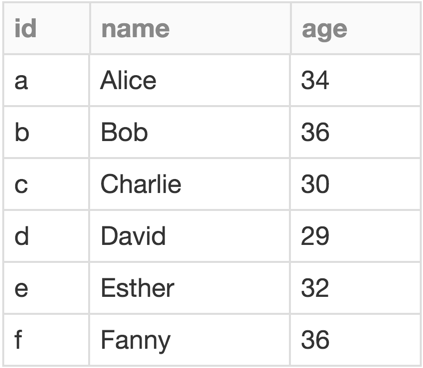

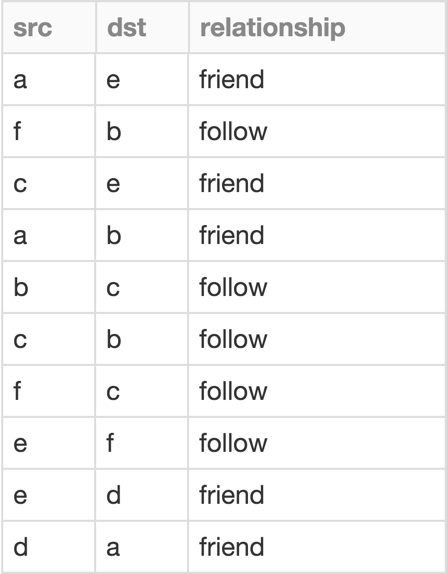

In [43]:
from pyspark.sql import SQLContext

### Create a GraphFrame from vertex and edge DataFrames

In [45]:
spark = SparkSession.builder.appName('graphframes').getOrCreate()
spark.sparkContext.addPyFile(
    "/opt/spark/jars/graphframes-0.8.2-spark3.0-s_2.12.jar")


In [46]:
from graphframes import *
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

In [47]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

vertices = spark.createDataFrame([
    ('a', 'Alica', 34),
    ('b', 'Bob', 36),
    ('c', 'Chalie', 30),
    ('d', 'David', 29),
    ('e', 'Esther', 32),
    ('f', 'Fanny', 36),
    ('g', 'Gabby', 60),
], [
    "id", "name", "age"
])

edges = spark.createDataFrame([
    ('a', 'b', 'friend'),
    ('b', 'c', 'follow'),
    ('c', 'b', 'follow'),
    ('f', 'c', 'follow'),
    ('e', 'f', 'follow'),
    ('e', 'd', 'friend'),
    ('d', 'a', 'friend'),
    ('a', 'e', 'friend'),
], [
    "src", "dst", "relationship"
])

graph = GraphFrame(vertices, edges)


### Take a look at the DataFrames

Get vertices, edges, and check the number of edges of each vertex

In [49]:
vertices.show()


+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alica| 34|
|  b|   Bob| 36|
|  c|Chalie| 30|
|  d| David| 29|
|  e|Esther| 32|
|  f| Fanny| 36|
|  g| Gabby| 60|
+---+------+---+



In [50]:
edges.show()


+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [51]:
graph.inDegrees.show()


+---+--------+
| id|inDegree|
+---+--------+
|  f|       1|
|  e|       1|
|  d|       1|
|  c|       2|
|  b|       2|
|  a|       1|
+---+--------+



In [52]:
graph.degrees.show()

+---+------+
| id|degree|
+---+------+
|  f|     2|
|  e|     3|
|  d|     2|
|  c|     3|
|  b|     3|
|  a|     3|
+---+------+



## Create UDF Functions 
convert your graph by mapping a function over the edges DataFrame that deletes the row if src ≥ dst return "Delete" else "Keep"

In [53]:
copy = edges
from pyspark.sql.functions import udf
def to_undir(src, dst):
    if src >= dst:
        return 'Delete'
    else: 
        return 'Keep'
    
udf_data = udf(to_undir)    
copy.withColumn('undir', udf_data(copy.src, copy.dst)).filter('undir == "Keep"').drop('undir').show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  e|  f|      follow|
|  a|  e|      friend|
+---+---+------------+



# Filtering and connected components

Check vertices when "age" greater than 30 and check edges "relationship" equal "friend" 

In [56]:
graph.vertices.filter("age > 30").show()


+---+------+---+
| id|  name|age|
+---+------+---+
|  a| Alica| 34|
|  b|   Bob| 36|
|  e|Esther| 32|
|  f| Fanny| 36|
|  g| Gabby| 60|
+---+------+---+



In [58]:
graph.edges.filter('relationship = "friend"').show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



GraphFrames requires you to set a directory where it can save checkpoints. Create such a folder in your working directory 

In [59]:
spark.sparkContext.setCheckpointDir('graphframesCheckPoint')

Then, the connected components can easily be computed with the connectedComponents-function.


In [61]:
graph.connectedComponents().show()

+---+------+---+------------+
| id|  name|age|   component|
+---+------+---+------------+
|  a| Alica| 34|412316860416|
|  b|   Bob| 36|412316860416|
|  c|Chalie| 30|412316860416|
|  d| David| 29|412316860416|
|  e|Esther| 32|412316860416|
|  f| Fanny| 36|412316860416|
|  g| Gabby| 60|146028888064|
+---+------+---+------------+



## Motif finding


Search for pairs of vertices a,b connected by edge e and pairs of vertices b,c connected by edge e2. It will return a DataFrame of all such structures in the graph

In [62]:
motifs = graph.find("(a)-[e]->(b);(b)-[e2]->(c)")
motifs.show()

+---------------+--------------+---------------+--------------+---------------+
|              a|             e|              b|            e2|              c|
+---------------+--------------+---------------+--------------+---------------+
| [a, Alica, 34]|[a, e, friend]|[e, Esther, 32]|[e, f, follow]| [f, Fanny, 36]|
| [d, David, 29]|[d, a, friend]| [a, Alica, 34]|[a, e, friend]|[e, Esther, 32]|
| [a, Alica, 34]|[a, e, friend]|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|
|[e, Esther, 32]|[e, f, follow]| [f, Fanny, 36]|[f, c, follow]|[c, Chalie, 30]|
|[c, Chalie, 30]|[c, b, follow]|   [b, Bob, 36]|[b, c, follow]|[c, Chalie, 30]|
| [a, Alica, 34]|[a, b, friend]|   [b, Bob, 36]|[b, c, follow]|[c, Chalie, 30]|
| [f, Fanny, 36]|[f, c, follow]|[c, Chalie, 30]|[c, b, follow]|   [b, Bob, 36]|
|   [b, Bob, 36]|[b, c, follow]|[c, Chalie, 30]|[c, b, follow]|   [b, Bob, 36]|
| [d, David, 29]|[d, a, friend]| [a, Alica, 34]|[a, b, friend]|   [b, Bob, 36]|
|[e, Esther, 32]|[e, d, friend]| [d, Dav

In [64]:
motifs = graph.find("(a)-[e]->(b);(b)-[e2]->(c)").filter('e.relationship = "friend" and e2.relationship = "friend"')
motifs.show()

+---------------+--------------+---------------+--------------+---------------+
|              a|             e|              b|            e2|              c|
+---------------+--------------+---------------+--------------+---------------+
| [d, David, 29]|[d, a, friend]| [a, Alica, 34]|[a, e, friend]|[e, Esther, 32]|
| [a, Alica, 34]|[a, e, friend]|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|
| [d, David, 29]|[d, a, friend]| [a, Alica, 34]|[a, b, friend]|   [b, Bob, 36]|
|[e, Esther, 32]|[e, d, friend]| [d, David, 29]|[d, a, friend]| [a, Alica, 34]|
+---------------+--------------+---------------+--------------+---------------+



In [65]:
motifs.filter('a.id == "c" and c.id == "d"').show()

+---+---+---+---+---+
|  a|  e|  b| e2|  c|
+---+---+---+---+---+
+---+---+---+---+---+

